 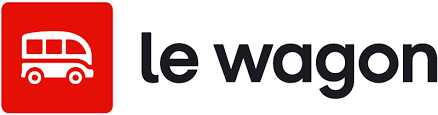

# Instagram likes prediction

We would like to predict the Greenweez turnover based on its past values

➡️ We have access to the sales from 2019 to 2021.

## Load data

a) Execute the cell below to load the data into `df` variable.

What does this SQL query do?

In [11]:
import os

# Charger le chemin depuis le fichier texte
with open(".path_repo.txt", "r") as f:
    path_repo = f.read().strip()

os.chdir(path_repo)

In [12]:
import pandas as pd

df = pd.read_csv("data\gwz_turnover.csv")
df

<>:3: SyntaxWarning:

invalid escape sequence '\g'

<>:3: SyntaxWarning:

invalid escape sequence '\g'

C:\Users\Vincent\AppData\Local\Temp\ipykernel_9852\413979516.py:3: SyntaxWarning:

invalid escape sequence '\g'



,day,turnover
0,2019-01-01,44701.68
1,2019-01-02,70769.80
2,2019-01-03,63244.24
3,2019-01-04,57895.95
4,2019-01-05,57288.99
...,...,...
1091,2021-12-27,59637.44
1092,2021-12-28,55751.96
1093,2021-12-29,51504.27
1094,2021-12-30,58154.98


In [13]:
import plotly.express as px

fig = px.line(df, "day", "turnover")
fig.show()

We can detect seasonality on this time serie : turnover drops at the end of each year.

We will try to predict the last month on December based on previous data.

## Using ARIMA model

In [14]:
!pip install sktime -q
!pip install pmdarima -q

Let's keep the last month on December 2021 as the test set to evaluate our prediction. We will set `test_size` parameter to 30.

We can use pandas functions or `temporal_train_test_split` from `sktime.forecasting.model_selection` to split our data into train and test.


In [15]:
from sktime.forecasting.model_selection import temporal_train_test_split

df_train, df_test = temporal_train_test_split(df, test_size=30)

AutoARIMA is a module to search for best parameters and will fit to the best model.

In [16]:
from sktime.forecasting.arima import AutoARIMA

arima = AutoARIMA()
arima.fit(df_train['turnover'])

AutoARIMA()

In [17]:
# best model here is SARIMAX(0, 1, 2)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1066
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -12015.955
Date:                Fri, 23 May 2025   AIC                          24037.911
Time:                        15:49:09   BIC                          24052.823
Sample:                             0   HQIC                         24043.561
                               - 1066                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4044      0.021    -18.922      0.000      -0.446      -0.363
ma.L2         -0.3749      0.026    -14.566      0.000      -0.425      -0.324
sigma2      3.658e+08   1.62e-11   2.26e+19      0.000    3.66e+08    3.66e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2032.74
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+35. Standard errors may be unstable.
"""

Our model is now ready to make a forecast using the method `predict`.
Assign the prediction for the df_test to a `pred_arima` variable.

In [18]:
pred_arima = arima.predict(list(range(1,31)))
df_test["pred_arima"] = pred_arima

C:\Users\Vincent\AppData\Local\Temp\ipykernel_9852\2487360535.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
import plotly.express as px

fig = px.line(df_test.set_index("day"))
fig.show()

The metric **Mean Absolute Percentage Error (MAPE)** is used to compare performance on time series.
This metric is the one used by the method `score`. Assign it to the variable `score_arima`.

In [20]:
score_arima=arima.score(df_test['turnover'])
score_arima

0.8828367548393471

88%, the model is pretty bad...
MAPE should be close to 0.

Arima model needs to be tuned to perform better.

## Using PROPHET model

In [ ]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------- ----------- 9.4/13.3 MB 58.4 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 55.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/954.8 kB ? eta -:--:--
   ---------------------------------------- 954.8/954.8 kB ? eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.24
    Uninstalling holidays-0.24:
      Successfully uninstalled holidays-0.24


Import the libraries

In [27]:
import datetime
from prophet import Prophet

We want to use the PROPHET model from Facebook to train our model and make a prediction for future turnover.

We want to use the same trainning values than our first ARIMA model (values until 1st Dec 2021) and test our prediction with the same values (month of December 2021).

16:07:10 - cmdstanpy - INFO - Chain [1] start processing
16:07:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Vincent\AppData\Local\Temp\ipykernel_9852\991569878.py:23: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



MAPE: 17.91 %


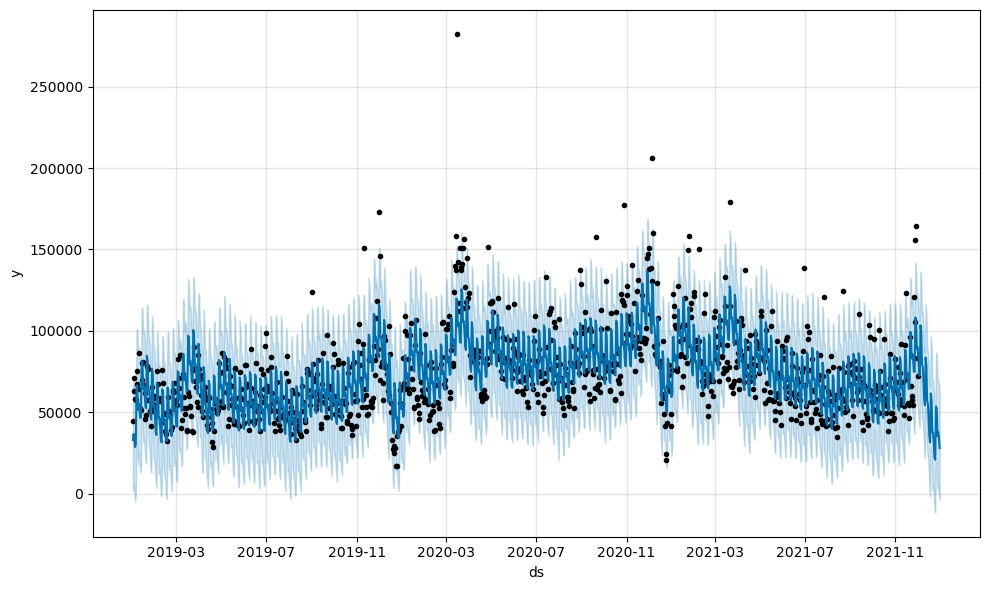

In [ ]:
from prophet import Prophet
import pandas as pd
import datetime

# --- Prepare the data ---
# Rename columns to match Prophet's expected format
df_prophet = df.rename(columns={"day": "ds", "turnover": "y"})

# Split into training and testing sets based on date
train = df_prophet[df_prophet["ds"] <= "2021-12-01"]
test = df_prophet[df_prophet["ds"] > "2021-12-01"]

# --- Configure and fit the Prophet model ---
model = Prophet(interval_width=0.95)
model.fit(train)

# --- Forecast the next 30 days ---
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)

# --- Evaluate forecast performance on the test set ---
# Filter predictions for test dates
forecast_test = forecast[forecast["ds"].isin(test["ds"])]
y_pred = forecast_test["yhat"].values
y_true = test["y"].values

# Compute MAPE
mape = (abs((y_true - y_pred) / y_true)).mean() * 100
print("MAPE:", round(mape, 2), "%")

# --- Plot the forecast ---
model.plot(forecast);